In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import normalize


import os
import pathlib
import sys
import matplotlib.pyplot as plt
from scipy import linalg


sys.path.append(os.path.join(pathlib.Path(os.getcwd()).parent))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from utils.bq_conn import bq_conn_file
# %%
bq_client = bq_conn_file(project_id="dsa-miad-365616")

In [2]:
pd.options.display.max_columns = None

query = '''
SELECT
    *
FROM `Proyecto.DatosSecopI`
ORDER BY anno_cargue_secop DESC
'''
bq_client = bq_conn_file(project_id="dsa-miad-365616")
secop_I = bq_client.execute_query(query=query)
#print(f"El número de filas del dataset: {secop_I.shape[0]}\nEl número de columnas del dataset: {secop_I.shape[1]}")
secop_I.head(5)

,uid,anno_cargue_secop,id_modalidad,modalidad_de_contratacion,estado_del_proceso,id_objeto_a_contratar,detalle_del_objeto_a_contratar,tipo_de_contrato,municipio_de_obtencion,municipios_ejecucion_,departamento_ejecucion,numero_de_proceso,numero_de_contrato,cuantia_proceso,id_grupo,nombre_grupo,id_familia,nombre_familia,id_clase,nombre_clase,id_adjudicacion,tipo_identifi_del_contratista,identificacion_del_contratista,nom_razon_social_contratista,tipo_doc_representante_legal,identific_representante_legal,plazo_de_ejec_del_contrato_,dias_ejec_final_contrato,rango_de_ejec_del_contrato,prorrogado,tiempo_adiciones_en_dias,cuantia_contrato,con_adicion_pptal,valor_total_de_adiciones,valor_contrato_con_adiciones,moneda,objeto_del_contrato_a_la,ruta_proceso_en_secop_i
0,191389136418143424,2019,13,contratacion minima cuantia,celebrado,50000000,contratar servicio suministro elementos materi...,suministro,facatativa,facatativa,cundinamarca,CPMMSFFAMCNo01DE2019,CPMMSFFAMCNO01DE2019,50000000,E,productos de uso final,5022,productos de cereales legumbres,502213,harina productos de molinos,8143424,nit de persona juridica,900791326,inversiones ocazo,cedula de ciudadania,1022363447,330,330,D,0,0,50000000,0,0,50000000,peso colombiano,contratar compra elementos materia prima para ...,{'url': 'https://www.contratos.gov.co/consulta...
1,1912101041779226352,2019,12,contratacion directa ley de,celebrado,53000000,adquisicion uniformes para dotar personal cuer...,prestacion de servicios,bogota,bogota,bogota,DIRGENERALCONTRATACIONDIRECTA184DE2019,184DE2019,22980096902,E,productos de uso final,5310,ropa,531027,uniformes,9226352,nit de persona juridica,860020227,fondo rotatorio de la policia forpo,nit de persona juridica,860020227,660,690,D,1,30,22980096902,0,0,22980096902,peso colombiano,adquisicion uniformes para dotar personal cuer...,{'url': 'https://www.contratos.gov.co/consulta...
2,1912101443259265538,2019,12,contratacion directa ley de,celebrado,55000000,contratar diseno produccion tarjetas presentac...,prestacion de servicios,bogota,bogota,bogota,DIRGENERALCONTRATACIONDIRECTA188DE2019,188DE2019,35998452,E,productos de uso final,5510,medios impresos,551015,publicaciones impresas,9265538,nit de persona juridica,830001113,imprenta nacional de colombia,nit de persona juridica,830001113,31,71,D,1,40,35998452,0,0,35998452,peso colombiano,contratar diseno produccion tarjetas presentac...,{'url': 'https://www.contratos.gov.co/consulta...
3,191294985788644918,2019,12,contratacion directa ley de,liquidado,72000000,prestar servicio mantenimiento preventivo corr...,prestacion de servicios,bogota,bogota,bogota,DIRGENERALCONTRATACIONDIRECTA106DE2019,106DE2019,16767536,F,servicios,7210,servicios de mantenimiento reparaciones de con...,721015,servicios de apoyo para la construccion,8644918,nit de persona juridica,860025639,mitsubishi electric de colombia limitada,nit de persona juridica,860025639,170,170,D,0,0,16767536,0,0,16767536,peso colombiano,prestar servicio mantenimiento preventivo corr...,{'url': 'https://www.contratos.gov.co/consulta...
4,191988590538059861,2019,19,asociacion publico privada,celebrado,73000000,desintegracion vehiculos automotores estado in...,no encontrado en hoja proceso,bogota,bogota,bogota,CONVENIODEASOCIACIÓN231DE2018,231DE2018,0,F,servicios,7318,servicios de maquinado procesado,731810,servicios de maquinado,8059861,nit de persona juridica,806011019,recuperaciones naranjo recycling sas,cedula de ciudadania,57439563,360,360,D,0,0,0,0,0,0,peso colombiano,desintegracion vehiculos automotores estado in...,{'url': 'https://www.contratos.gov.co/consulta...


In [3]:
secopI_filter = secop_I.filter(items=['tipo_de_contrato', 
                'id_grupo', 
                'cuantia_proceso',
                'departamento_ejecucion',
                'plazo_de_ejec_del_contrato_',
                'id_objeto_a_contratar',
                'valor_total_de_adiciones',
                                      ])
secopI_filter.head(5)


,tipo_de_contrato,id_grupo,cuantia_proceso,departamento_ejecucion,plazo_de_ejec_del_contrato_,id_objeto_a_contratar,valor_total_de_adiciones
0,suministro,E,50000000,cundinamarca,330,50000000,0
1,prestacion de servicios,E,22980096902,bogota,660,53000000,0
2,prestacion de servicios,E,35998452,bogota,31,55000000,0
3,prestacion de servicios,F,16767536,bogota,170,72000000,0
4,no encontrado en hoja proceso,F,0,bogota,360,73000000,0


In [4]:
secopI_filter['tipo_de_contrato'] = secopI_filter['tipo_de_contrato'].astype('category')
secopI_filter['departamento_ejecucion'] = secopI_filter['departamento_ejecucion'].astype('category')
secopI_filter['id_objeto_a_contratar'] = secopI_filter['id_objeto_a_contratar'].astype('category')
secopI_filter['cuantia_proceso'] = secopI_filter['cuantia_proceso'].astype('int')
secopI_filter['plazo_de_ejec_del_contrato_'] = secopI_filter['plazo_de_ejec_del_contrato_'].astype('int')

In [5]:
secopI_filter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26553 entries, 0 to 26552
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   tipo_de_contrato             26553 non-null  category
 1   id_grupo                     26553 non-null  object  
 2   cuantia_proceso              26553 non-null  int64   
 3   departamento_ejecucion       26553 non-null  category
 4   plazo_de_ejec_del_contrato_  26553 non-null  int64   
 5   id_objeto_a_contratar        26553 non-null  category
 6   valor_total_de_adiciones     26553 non-null  Int64   
dtypes: Int64(1), category(3), int64(2), object(1)
memory usage: 937.8+ KB


In [6]:
train_dataset = secopI_filter.sample(frac=0.95,random_state=0)
test_dataset = secopI_filter.drop(train_dataset.index)

# Xtrain
train_X = train_dataset.drop(['valor_total_de_adiciones'], axis=1)
test_X = test_dataset.drop(['valor_total_de_adiciones'], axis=1)
# Ytrain
train_labels = train_dataset.pop('valor_total_de_adiciones')
test_labels = test_dataset.pop('valor_total_de_adiciones')

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

numeric_cols = train_dataset.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = train_dataset.select_dtypes(include=['object', 'category']).columns.to_list()

# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[
                            ('imputer', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler())
                        ]
                      )


# Transformaciones para las variables categóricas
categorical_transformer = Pipeline(
                            steps=[
                                ('imputer', SimpleImputer(strategy='most_frequent')),
                                ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
                            ]
                          )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)
                    ],
                    remainder='passthrough',
                    verbose_feature_names_out = False
               ).set_output(transform="pandas")

data_prep = preprocessor.fit_transform(train_dataset)
data_test = preprocessor.transform(test_dataset)

In [12]:
from pickle import dump
# save the scaler
dump(preprocessor, open('/Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/utils/preprocessor_keras.pkl', 'wb'))

In [13]:
def build_model ():
  model = keras.Sequential([
    layers.Dense(6, activation='relu', input_shape=[len(data_prep.keys())]),
    layers.Dense(3, activation='relu'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [14]:
model = build_model()

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 642       
                                                                 
 dense_1 (Dense)             (None, 3)                 21        
                                                                 
 dense_2 (Dense)             (None, 1)                 4         
                                                                 
Total params: 667
Trainable params: 667
Non-trainable params: 0
_________________________________________________________________


In [16]:
train_data = np.asarray(data_prep).astype(np.float32)
test_data = np.asarray(data_test).astype(np.float32)

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model_folder = "/Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto"
mc = ModelCheckpoint(model_folder, monitor='val_loss', verbose=0, save_best_only=True)

In [18]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 200

from keras import backend as K
train_data = K.cast_to_floatx(train_data)
train_labels = K.cast_to_floatx(train_labels)

history = model.fit(
  train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot(), mc])

2023-05-23 08:46:43.695052: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz



.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets



.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


.INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


INFO:tensorflow:Assets written to: /Users/nataliajimenez/Documents/Master_IA/proyecto-grado-miad/app_tool/models/keras_model_monto/assets


In [19]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
print(hist)

             loss           mae           mse      val_loss       val_mae  \
0    4.661429e+13  7.436680e+05  4.661429e+13  2.207416e+14  9.247009e+05   
1    4.661426e+13  7.436731e+05  4.661426e+13  2.207416e+14  9.247082e+05   
2    4.661423e+13  7.436841e+05  4.661423e+13  2.207415e+14  9.247216e+05   
3    4.661419e+13  7.437028e+05  4.661419e+13  2.207415e+14  9.247439e+05   
4    4.661412e+13  7.437302e+05  4.661412e+13  2.207413e+14  9.247781e+05   
..            ...           ...           ...           ...           ...   
195  4.492643e+13  1.175520e+06  4.492643e+13  2.185298e+14  1.338129e+06   
196  4.492102e+13  1.175078e+06  4.492102e+13  2.185214e+14  1.337817e+06   
197  4.491487e+13  1.175164e+06  4.491487e+13  2.185127e+14  1.337594e+06   
198  4.490829e+13  1.175102e+06  4.490829e+13  2.185033e+14  1.337591e+06   
199  4.490235e+13  1.175081e+06  4.490235e+13  2.184947e+14  1.337444e+06   

          val_mse  epoch  
0    2.207416e+14      0  
1    2.207416e+14    

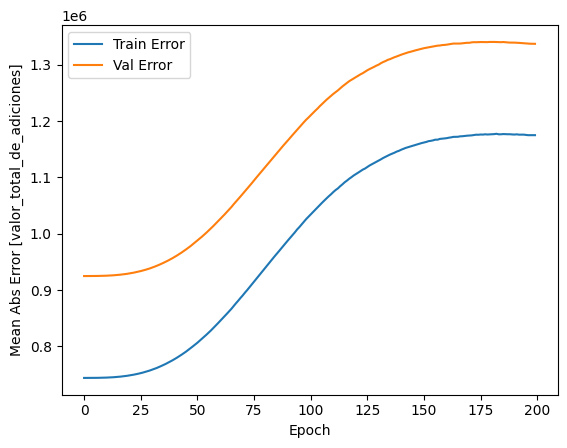

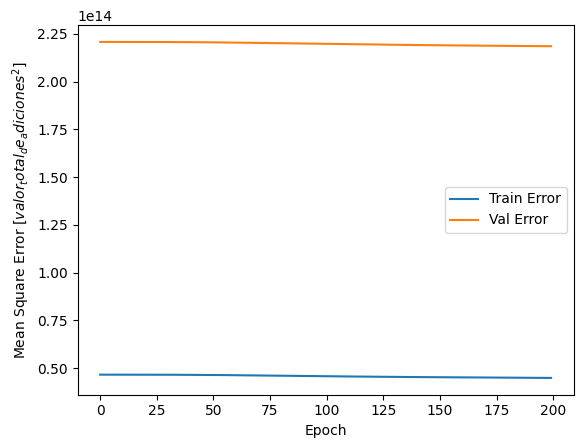

In [20]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [valor_total_de_adiciones]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$valor_total_de_adiciones^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.legend()
  plt.show()


plot_history(history)

In [40]:
example_result = model.predict(np.array(test_data[:]))
resultados = pd.DataFrame(example_result)
resultados.columns = ['resultados']
resultados

42/42 [==============================] - 0s 348us/step


,resultados
0,6839354.0
1,6847374.5
2,7167595.5
3,6015085.5
4,7477883.0
...,...
1323,6936737.0
1324,5569015.0
1325,5929912.0
1326,5891836.5


In [43]:
test_labels = pd.DataFrame(test_labels)
compare = pd.concat([resultados, test_labels], axis=1)
compare = compare.fillna(0)

In [45]:
test_labels

,valor_contrato_con_adiciones
62,2987670
63,4413200
79,3971880
93,3530560
99,1765280
...,...
26414,350000
26447,4743120
26472,300632
26478,0


In [47]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse_t = mean_squared_error(compare['resultados'], compare['valor_contrato_con_adiciones'])
mae_t = mean_absolute_error(compare['resultados'], compare['valor_contrato_con_adiciones'])
print("El MSE test:", mse_t)
print("El MAE test:", mae_t)


El MSE test: 5.684695949979628e+16
El MAE test: 15817450.541103821


In [53]:
weights = model.get_weights()[0]
biases = model.get_weights()[1]

# Imprimir los coeficientes
print("Coeficientes (m):")
for i, w in enumerate(weights):
    print(f"m{i+1}: {w[0]}")

print("")

# Imprimir el sesgo (intercepto) (B)
print("Sesgo (B):")
print(biases[0])

Coeficientes (m):
m1: -5.521910190582275
m2: -4.73265266418457
m3: -3.624376058578491
m4: -1.7713463306427002
m5: -7.766342639923096
m6: 2.1537187099456787
m7: 1.6838548183441162
m8: 12.38211727142334

Sesgo (B):
9.865838
